# Data Science Component Building 
### time series analysis, classification of headlines,topic modelling and sentimenta analysis and predictive analysis and modelling among various global media agencies

This section aims to build various models for our data inorder to gain a deeper understanding. Using the insights we gained from the EDA, we create various pipelines.


## Tools

I'll be using the library like nltk, sklearn, gensim and various other libraries to facilitate in creating various models


In [1]:
# preparing and importing the necessary packages 
import pandas as pd
import numpy as np
import sys
import os
# Manually setting the correct path to src directory
sys.path.append("../../../OFFICAL WEEK0")

from src.loader import NewsDataLoader
from src.db_export import DatabaseExporter
import src.utils_ml as utils_ml
import src.utils as utils


In [2]:
# defining the appropriate path for each path
path = {
    "rating":"../../data/cleaned_rating.csv",
    "domains_location":os.environ['DOMAINS_LOCATION_PATH'],
    "traffic":"../../data/cleaned_traffic.csv"}

# initiating the newsdataloader class
data_loader = NewsDataLoader(path)

In [3]:
# importing relevant data by using the NewsDataloader class 
rating = data_loader.get_data("rating")

domains_location = data_loader.get_data("domains_location")

traffic = data_loader.get_data("traffic")

In [4]:
domains_location_names = {"SourceCommonName":"domain"}
domains_location.rename(columns=domains_location_names,inplace=True)

### For further analysis let's take in the data and clean it up for nltk

## Text cleaning

### Removing noise

we will be doing the following:
* Remove the stopwords.
* Make all the text lowercase.
* Remove punctuation.
* Normalizing the data by using lemmatization.

In [5]:
rating[["title","content"]] = rating[["title","content"]].map(utils_ml.pre_process)

once the data is cleaned we can use TfidfVectorizer and cosine similarity which is included in the "extract_similarity" function which recieves two columns and sets the similarity among them in the third column 

In [6]:
utils_ml.extract_similarity(rating,"title","content","title_content_similarity")

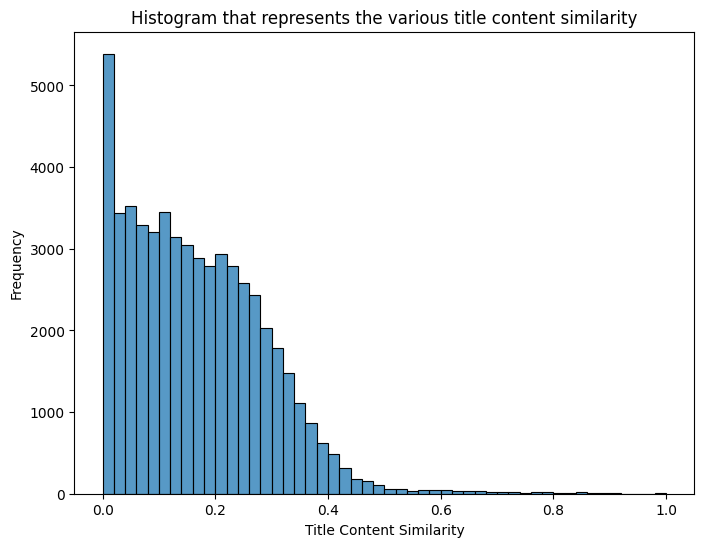

In [7]:
utils.histogram(rating,rating["title_content_similarity"],"Histogram that represents the various title content similarity","Title Content Similarity","Frequency",figsize=(8,6),bins=50)

the histogram shows that there is not much similarity between the content and title

next for further analysis let's add the keywords to each column

In [8]:
top_features = utils_ml.key_word_extractor(rating["content"])

In [9]:
top_features

,top_keywords
0,"[london, pavyllon, lane, hotel, park, season, ..."
1,"[nice, hicham, clermont, boudaoui, lowly, seco..."
2,"[amphibian, salamander, newt, frog, 2579, stud..."
3,"[sediment, redorange, ironrich, betsiboka, 756..."
4,"[sayi, 3913, existential, streamer, lineup, ma..."
...,...
54578,"[troublesthe, shivakumar, 2527, karnataka, wro..."
54579,"[fc, barcelona, mundo, 7676, deportivo, europa..."
54580,"[david, story, lubarskys, lubarsky, unsung, fe..."
54581,"[farm, kerbers, bringing, village, west, 4513,..."


In [10]:
rating.reset_index(drop=True, inplace=True)
top_features.reset_index(drop=True, inplace=True)
rating = pd.concat([rating, top_features], axis=1)

In [11]:
topics = {
    "Breaking News": ["breaking", "news", "update", "latest", "developing"],
    "Politics": ["politics", "government", "election", "candidate", "party"],
    "World News": ["world", "global", "international", "foreign", "diplomacy"],
    "Business/Finance": ["business", "finance", "economy", "market", "stock"],
    "Technology": ["tech", "technology", "innovation", "gadget", "startup"],
    "Science": ["science", "research", "study", "experiment", "discovery"],
    "Health": ["health", "medicine", "wellness", "fitness", "disease"],
    "Entertainment": ["entertainment", "movie", "tv", "music", "celebrity"],
    "Sports": ["sports", "game", "team", "player", "championship"],
    "Environment": ["environment", "climate", "sustainability", "green", "eco"],
    "Crime": ["crime", "justice", "law", "police", "investigation"],
    "Education": ["education", "school", "university", "learning", "teacher"],
    "Weather": ["weather", "forecast", "climate", "storm", "hurricane"],
    "Other": ["misc", "general", "random", "unknown", "unclassified"]
}

For categorizing the text to the above topics let's use both the title and the extracted keywords

In [12]:

title_tag = pd.DataFrame(utils_ml.categorize_headlines(rating['title'], topics),columns=["title_tag"])

keyword_tag = pd.DataFrame(utils_ml.categorize_headlines(rating['top_keywords'].apply(lambda x:" ".join(x)), topics),columns=["keyword_tag"])

title_tag.reset_index(drop=True, inplace=True)
keyword_tag.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
title_keyword_merged = pd.concat([title_tag, keyword_tag], axis=1)

In [13]:
title_keyword_merged.reset_index(drop=True, inplace=True)
keyword_tag.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
title_keyword_merged = pd.concat([title_tag, keyword_tag], axis=1)

In [14]:
title_keyword_merged

,title_tag,keyword_tag
0,Other,Other
1,Other,Environment
2,World News,Other
3,Other,Other
4,Other,Other
...,...,...
54578,Politics,Other
54579,Other,Other
54580,Other,Other
54581,Other,Other


In [15]:
title_keyword_merged

,title_tag,keyword_tag
0,Other,Other
1,Other,Environment
2,World News,Other
3,Other,Other
4,Other,Other
...,...,...
54578,Politics,Other
54579,Other,Other
54580,Other,Other
54581,Other,Other


In [16]:
def combine_values(val1, val2):
    
    if val1 == 'Other':
        if val2 == "Other":
            return "Other"
        else:
            return val2
    else:
        if val2 == "Other":
            return val1
        elif val1 == val2 :
            return val1
        else:
            val1 = [x.strip() for x in val1.split(",")]
            val2 = [x.strip() for x in val2.split(",")]
            valcombined = val1+val2
            return ", ".join(list(set(valcombined)))
title_keyword_merged_result = title_keyword_merged.apply(lambda row: combine_values(*[row["title_tag"], row["keyword_tag"]]),axis=1)

In [17]:
title_keyword_merged_result.reset_index(drop=True, inplace=True)
rating.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
rating = pd.concat([rating, title_keyword_merged_result], axis=1)

In [18]:
# converting the names inorder to make easier for later
rating_names = {0:"categories_known"}
rating.rename(columns=rating_names,inplace=True)

### Topic Modeling

There are two ways to appraoch topic modeling, the first is using tfidfvectorizer with TruncatedSVD, the second is using an lda model 

Let's try both appraoches and check if there are similarities between the topics generated

#### First Approach : Using TfIdf Vectorizer with Truncated SVD

In [19]:
topic_vector_array_reduced, svd_model, terms = utils_ml.extract_topic_vectors(rating["title"])

utils_ml.topic_modelling_tfidf(svd_model, terms, n_components=10)

{'Topic 0': ['inc', 'share', 'stock', 'llc', 'holding', 'management', 'co'],
 'Topic 1': ['market', 'stock', 'billion', 'price', 'usd', 'cagr', 'global'],
 'Topic 2': ['share', 'market', 'billion', 'sell', 'usd', 'cagr', 'global'],
 'Topic 3': ['price', 'new', 'target', 'share', 'group', 'analyst', 'given'],
 'Topic 4': ['new', '2023', 'result', 'investment', 'llc', 'quarter', 'say'],
 'Topic 5': ['2023',
  'result',
  'financial',
  'quarter',
  'inc',
  'earnings',
  'third'],
 'Topic 6': ['inc', 'new', 'group', 'sell', 'analyst', 'interest', 'set'],
 'Topic 7': ['gaza', 'israel', 'say', 'war', 'hamas', 'stock', 'attack'],
 'Topic 8': ['stock', 'new', 'sell', 'share', 'co', 'update', 'insider'],
 'Topic 9': ['group',
  'stocknewscom',
  'rating',
  'buy',
  'coverage',
  'co',
  'analyst']}

Second Approach is to use LDA for topic modelling and assign which documents belong to which topic

we'll vectorize and then create and apply the LDA model. Detailed funcion implementatin is shown in the utils_ml file

In [20]:
lda_model,model_output,vectorizer,topics = utils_ml.topic_modelling_lda(rating['title'],10)

In [21]:
# displaying the topics
topics

{'Topic 0': ['future',
  'industry',
  'limited',
  'rating',
  'international',
  'day',
  'set',
  'target',
  '2023',
  'report'],
 'Topic 1': ['analyst',
  'earnings',
  'new',
  'llc',
  'company',
  'price',
  'investment',
  'group',
  'share',
  'inc'],
 'Topic 2': ['action',
  'hold',
  '2032',
  'research',
  'plan',
  'cut',
  'update',
  'trust',
  'cagr',
  'market'],
 'Topic 3': ['llc',
  'short',
  'interest',
  'growth',
  'ukraine',
  'corp',
  'stock',
  'capital',
  'position',
  'management'],
 'Topic 4': ['wealth',
  'asset',
  'service',
  'advisor',
  'financial',
  'buy',
  'llc',
  'million',
  'sell',
  'stock'],
 'Topic 5': ['trading',
  'system',
  'black',
  'make',
  'best',
  'dividend',
  'size',
  'deal',
  'inc',
  'holding'],
 'Topic 6': ['amid',
  'coverage',
  'top',
  'war',
  'stocknewscom',
  'usd',
  'india',
  'israel',
  'say',
  'gaza'],
 'Topic 7': ['show',
  'watch',
  'canada',
  '2023',
  '2024',
  'release',
  'first',
  'result',
  'rea

In [22]:
topicnames = ["Topic " + str(i) for i in range(10)]
docnames = ["Document " + str(i) for i in range(len(rating['title']))]

df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)
main_topic = np.argmax(df_document_topic.values, axis=1)

rating['main_topic'] = main_topic

c:\Users\alaza\OneDrive\Desktop\Offical Week0\notebooks\ML\../../../OFFICAL WEEK0\src\utils.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=45, horizontalalignment="right")


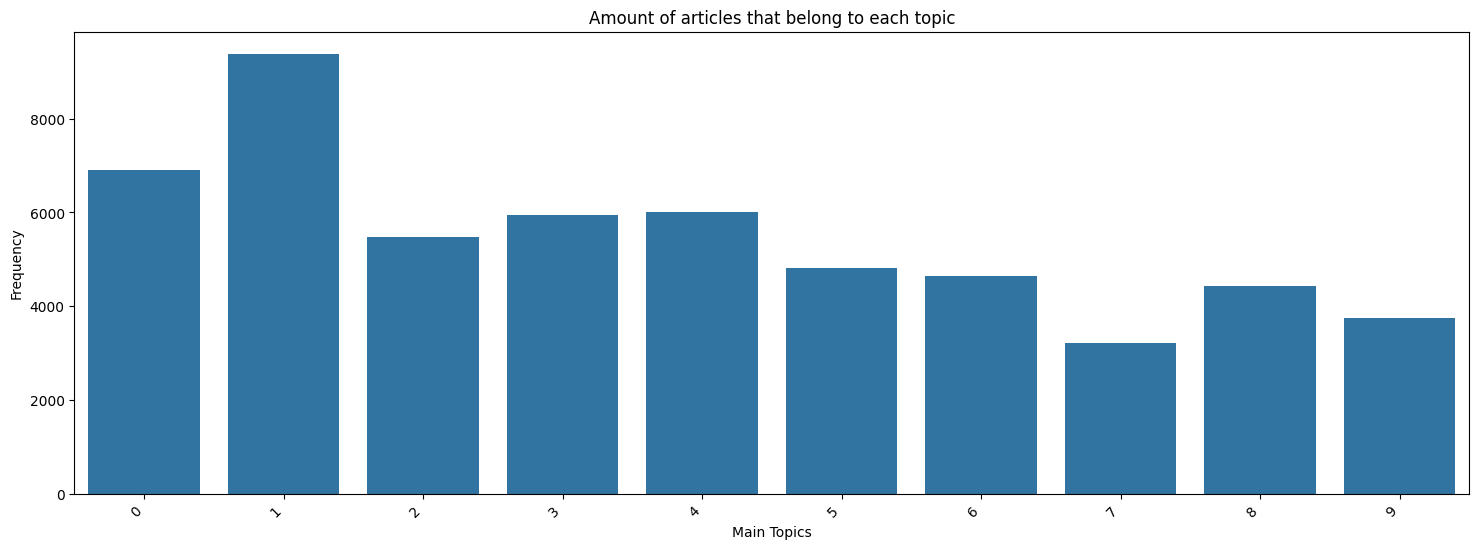

In [23]:
grouped_main_topic = rating.groupby("main_topic")["article_id"].count()
utils.barchart(x_axis=grouped_main_topic.index,y_axis=grouped_main_topic.values,x_label="Main Topics",y_label="Frequency",title="Amount of articles that belong to each topic",orientation="vertical")

[6902 9392 5468 5951 6006 4808 4644 3220 4439 3753]
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='main_topic')


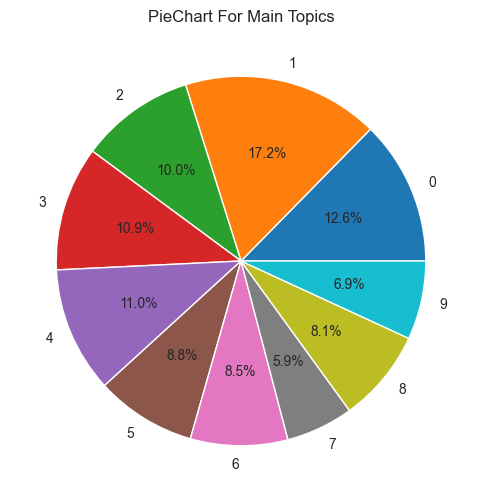

In [24]:
utils.pie_chart(title="PieChart For Main Topics",count=grouped_main_topic.values,labels=grouped_main_topic.index)
# utils.barchart(x_axis=grouped_main_topic.index,y_axis=grouped_main_topic.values,x_label="Main Topics",y_label="Frequency",title="Amount of articles that belong to each topic",orientation="vertical")

# Word Cloud Visualization

In [25]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Number of words per topic for the word cloud
n_top_words = 10

# Extract topics
topics = {}
for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_weights = topic[topic.argsort()[:-n_top_words - 1:-1]]
    topics[topic_idx] = dict(zip(topic_words, topic_weights))

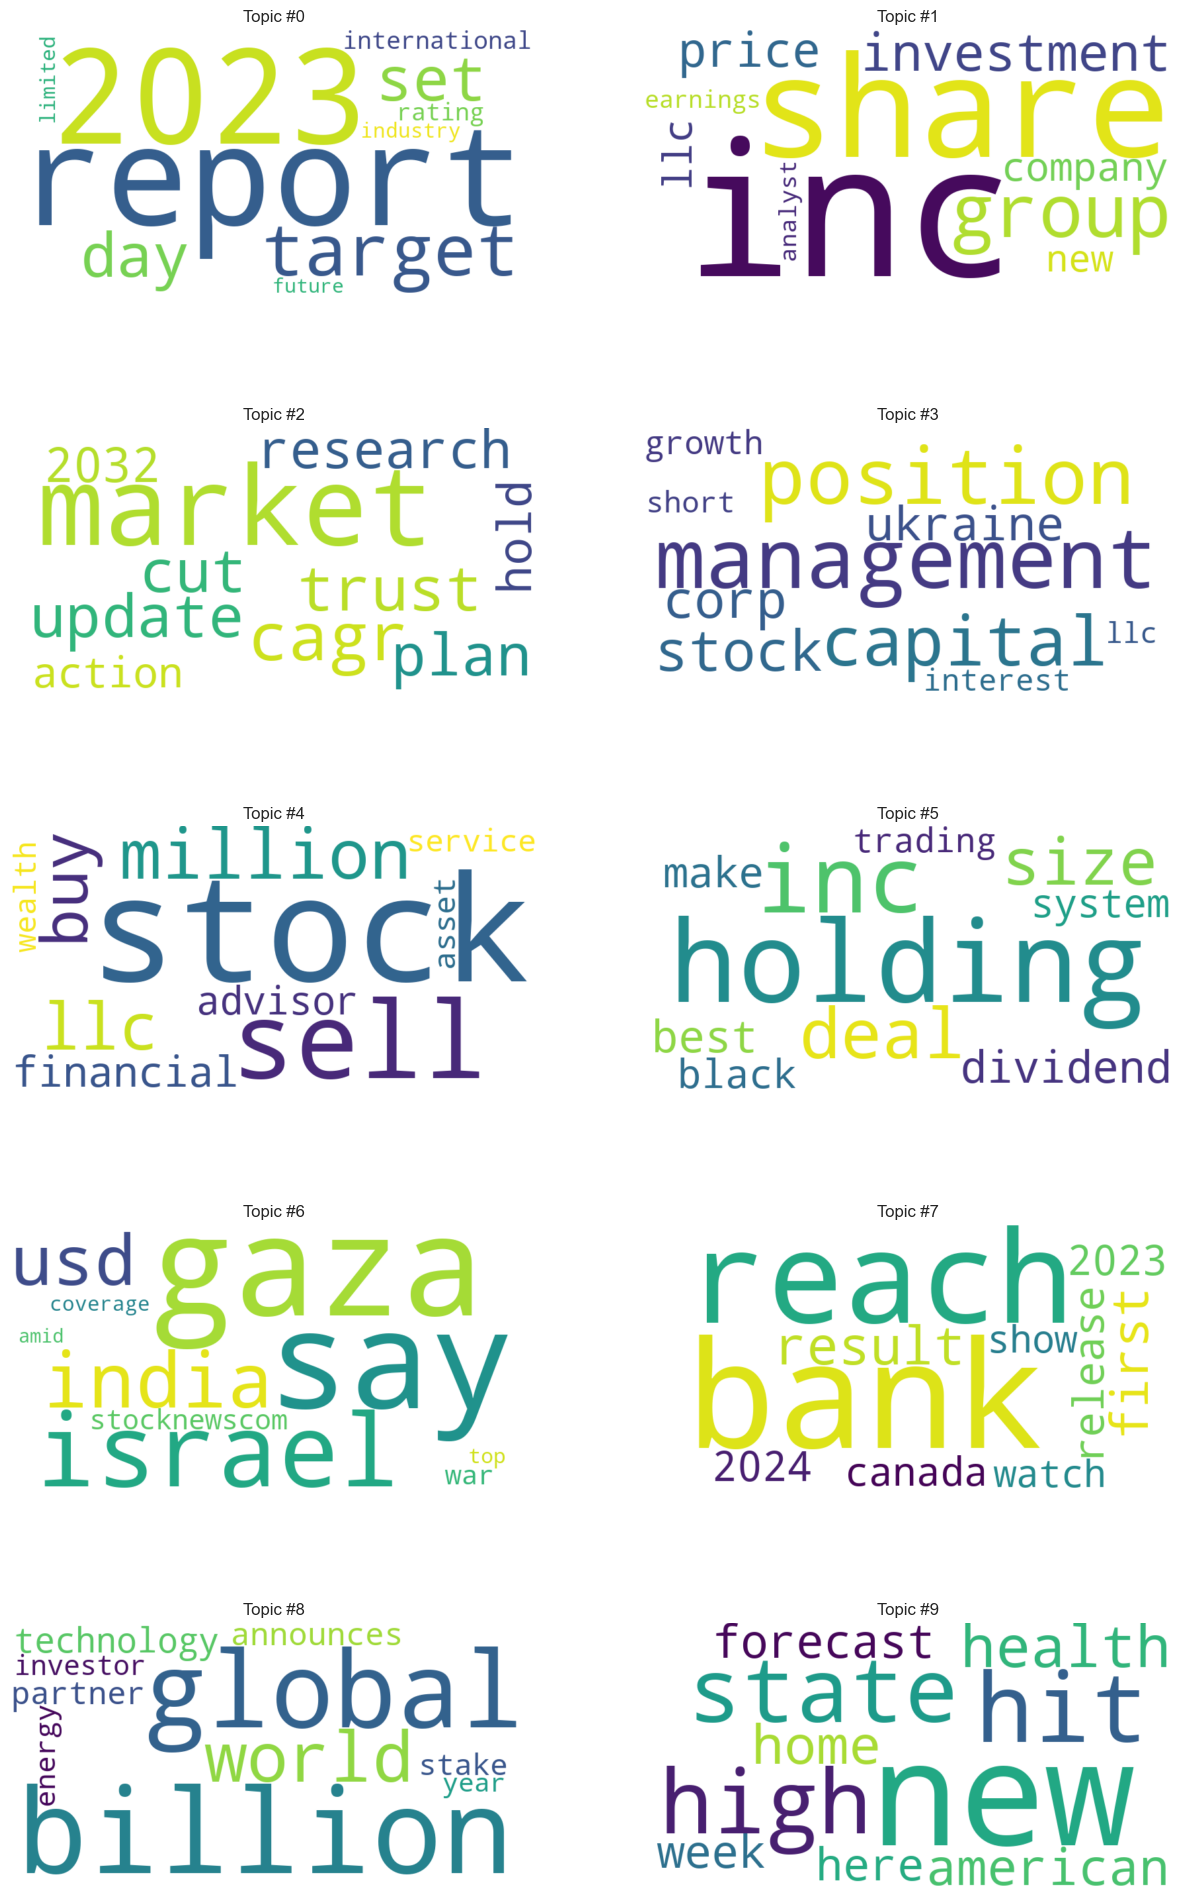

In [26]:
utils_ml.plot_word_cloud(topics)

### We've done the required topic modelling and categorizing articles into known categories now let's move on to modelling events

Since we will be using KMeans cluster we need to first find out the optimal cluster value. We'll test out cluster values from 2 to 21 to find the optimal value

In [27]:
from sklearn.cluster import KMeans

wcss = [] 
n_clusters = np.arange(2, 21)
for i in n_clusters: 
    kmeans = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=42)
    # using the topic vector array that was created during the tfidf topic modelling
    kmeans.fit(topic_vector_array_reduced) 
    wcss.append(kmeans.inertia_)

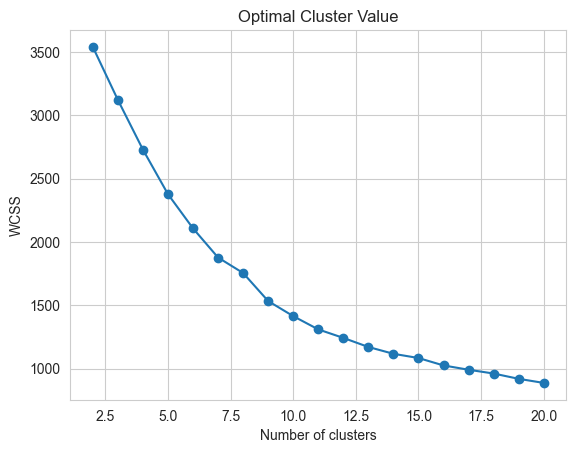

In [28]:
utils.line_graph(range(2,21),wcss,"Number of clusters","WCSS","Optimal Cluster Value")

### From the above figure our optimal k value is created between 10 and 12 so we will go with 11

In [29]:

kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300, random_state=42)
kmeans.fit(topic_vector_array_reduced) 

KMeans(n_init=10, random_state=42)

In [30]:
y_preds = kmeans.predict(topic_vector_array_reduced)
cluster_label = y_preds

### our first approach can be clustering the dataset based on the optimal amount of clusters using kmeans and reducing the feature amount using pca to make it easier for plotting

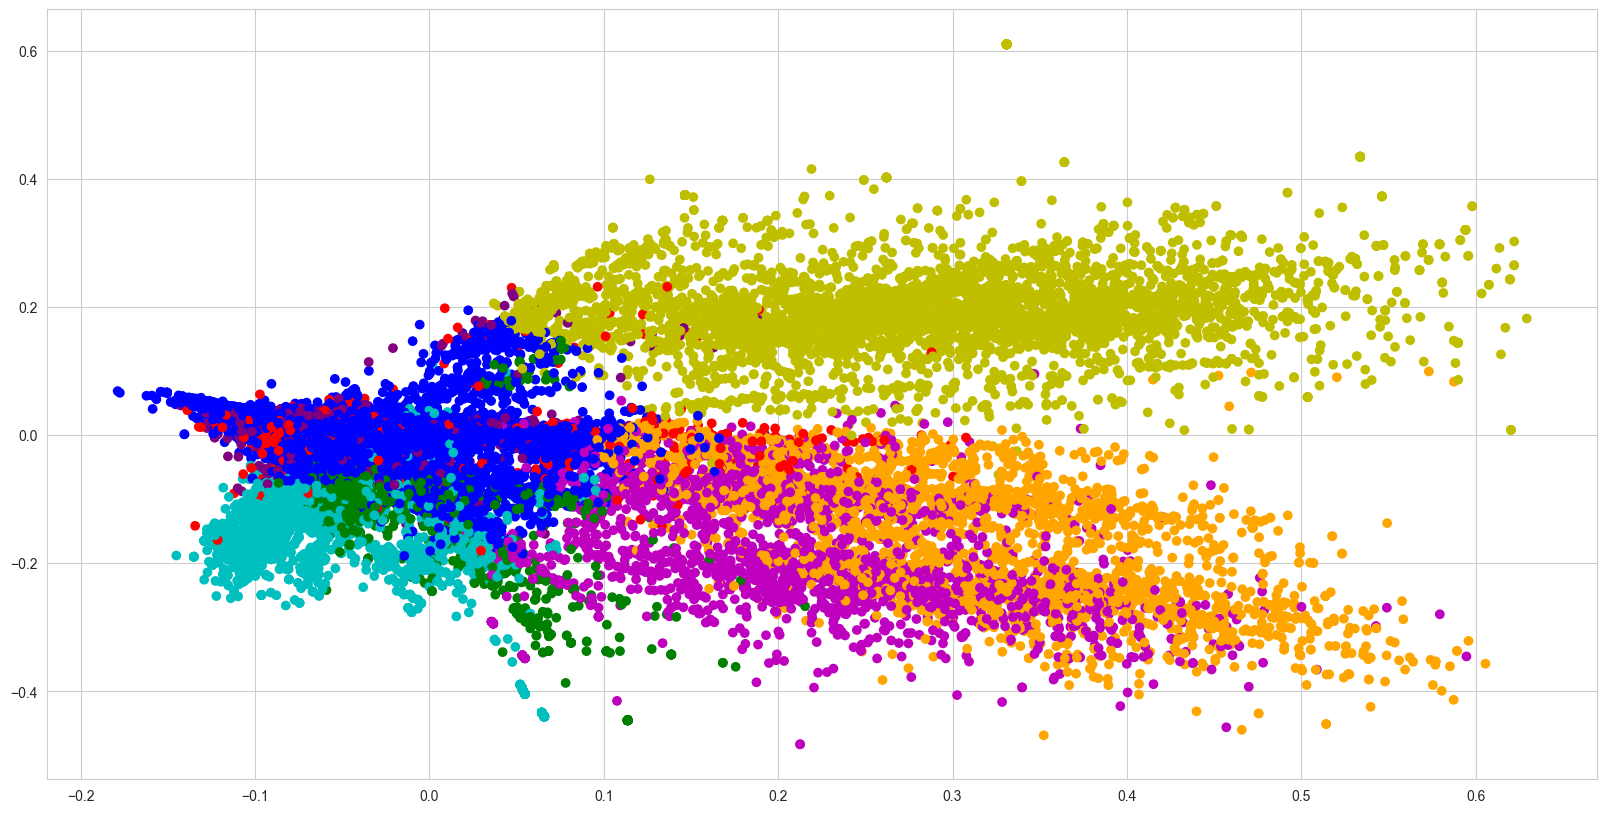

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(topic_vector_array_reduced)
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))
colors = [
    "r", "b", "c", "y", "m",  # Red, Blue, Cyan, Yellow, Magenta
    "g", "orange", "purple", "brown", "pink"  # Green, Orange, Purple, Brown, Pink, Grey
]

ax.scatter(x_axis, y_axis, c=[colors[d] for d in cluster_label])


this can clearly show that there are a lot of intersection between clusters but the issue arises when we want to think of clusters as events so let's try a different approach

### Model the events that the articles are covering

in order to have a lot of events and create a more accurate event relation let's create a cluster of 500 

In [32]:

kmeans = KMeans(n_clusters=500, n_init=10, max_iter=300, random_state=42)
kmeans.fit(topic_vector_array_reduced) 

KMeans(n_clusters=500, n_init=10, random_state=42)

In [33]:
# Add the cluster labels to the dataframe
rating['cluster'] = kmeans.labels_

In [34]:
from collections import Counter
# Label the clusters
cluster_labels = []
for cluster in range(500):
    # Get the articles in this cluster
    articles = rating[rating['cluster'] == cluster]['title']

    # Combine the articles into one long string
    text = ' '.join(articles)

    # Get the most common words in this text
    words = Counter(text.split())
    most_common_words = words.most_common(5)

    # Use the most common words as the cluster label
    label = ' '.join([word for word, _ in most_common_words])
    cluster_labels.append(label)
    

In [35]:
rating['event'] = rating['cluster'].apply(lambda x: cluster_labels[x])

In [36]:
rating.head()

,article_id,source_name,author,title,description,published_at,content,category,article,title_sentiment,...,title_length,content_length,content_based_region,category_based_region,title_content_similarity,top_keywords,categories_known,main_topic,cluster,event
0,81664,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,2023-11-01 03:27:21.000000,pavyllon london four season hotel london park ...,Monaco,"pavyllon london, at four seasons hotel london ...",Neutral,...,78,212,other,europe,0.174270,"[london, pavyllon, lane, hotel, park, season, ...",Other,5,465,u – dy — v
1,81667,CNA,NaN,nice claim top spot ligue 1 late win clermont,Nice moved into provisional first place in the...,2023-10-27 21:28:48.000000,nice moved provisional first place ligue 1 sta...,Monaco,nice moved into provisional first place in the...,Positive,...,56,212,other,europe,0.115526,"[nice, hicham, clermont, boudaoui, lowly, seco...",Environment,1,212,u china leader people death
2,81694,Time,Christina Larson / AP,amphibian world’s vulnerable specie threat inc...,"The world’s frogs, salamanders, newts, and oth...",2023-10-04 17:36:18.000000,world frog salamander newt amphibian remain se...,Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative,...,77,213,other,africa,0.112500,"[amphibian, salamander, newt, frog, 2579, stud...",World News,5,385,world cup india cricket first
3,81695,Phys.Org,Sara Schmidt,image rusty red water madagascar,Iron-rich sediment colors the red-orange water...,2023-10-31 18:04:02.000000,ironrich sediment color redorange water betsib...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral,...,37,213,africa,africa,0.085958,"[sediment, redorange, ironrich, betsiboka, 756...",Other,6,139,u head review google –
4,81703,Digital Trends,Jason Struss,everything leaving max formerly hbo max novemb...,From Gangs of London to Fear the Walking Dead ...,2023-10-23 23:09:18.000000,everything end no i’m existential crisis i’m l...,Madagascar,"everything ends. no, i’m not having an existen...",Neutral,...,58,214,other,africa,0.085426,"[sayi, 3913, existential, streamer, lineup, ma...",Other,6,379,2023 result earnings announces quarter


In [37]:
# The number of events covered in the data
num_events = rating['event'].nunique()
print(f"Number of events: {num_events}")

Number of events: 494


Analysing the news sites that report events the earliest

In [38]:
rating['date'] = pd.to_datetime(rating['published_at'],format='mixed')  # Ensure the date column is in datetime format
earliest_reporting = rating.sort_values('date').groupby('event').first()['source_name']
print("News sites that reported each event the earliest:")
print(earliest_reporting)

News sites that reported each event the earliest:
event
2023 best gift holiday result                   GlobeNewswire
2023 earnings result investment capital    Marketscreener.com
2023 group third quarter result            Marketscreener.com
2023 inc earnings q4 november                   GlobeNewswire
2023 inc third quarter result              Marketscreener.com
                                                  ...        
war israelhamas day key event              Al Jazeera English
war ukraine hamas attack israeli             Business Insider
world cup india australia final                           CNA
world cup india cricket first                        Deadline
year deal best first black                           Euronews
Name: source_name, Length: 494, dtype: object


Events with the highest reporting

In [39]:
event_counts = rating['event'].value_counts()
print("Events with the highest reporting:")
print(event_counts)

Events with the highest reporting:
event
u head review google –                     4312
u get climate change –                     3843
u – dy — v                                 2911
u china leader people death                2770
china president russia minister u          1506
                                           ... 
new financial 2 announces introducing         5
inc management new capital investment         5
new result announces 2023 third               5
new market cartilage mysizes naiz             4
chemical stock saurabh mukherjea gungho       2
Name: count, Length: 494, dtype: int64


The correlation between news sites reporting events?

Create a matrix where each cell represents the number of common events reported by a pair of news sites

In [40]:
correlation_matrix = pd.crosstab(rating['source_name'], rating['event'])
correlation_matrix = correlation_matrix.T.dot(correlation_matrix)
print("Correlation matrix of news sites reporting events:")
print(correlation_matrix)

Correlation matrix of news sites reporting events:
event                                    2023 best gift holiday result  \
event                                                                    
2023 best gift holiday result                                     3090   
2023 earnings result investment capital                            400   
2023 group third quarter result                                    345   
2023 inc earnings q4 november                                      476   
2023 inc third quarter result                                      740   
...                                                                ...   
war israelhamas day key event                                     2486   
war ukraine hamas attack israeli                                  3312   
world cup india australia final                                   3728   
world cup india cricket first                                     7316   
year deal best first black                                   

## The modelling phase is completed so we can proceed on exporting our data to the database

In [42]:
host = os.environ['DB_HOST']
database = os.environ['DB_DATABASE']
username = os.environ['DB_USERNAME']
password = os.environ['DB_PASSWORD']


# Create an instance of the DatabaseExporter class
exporter = DatabaseExporter(host, database, username, password)

# Create a dictionary to map DataFrame names to their corresponding DataFrames
df_dict = {'rating': rating, 'domains_location': domains_location, 'traffic': traffic}

# Run the exporter
try:
    exporter.run(df_dict)
except Exception as e:
    print(f"Error running exporter: {e}")

database exporter initiated
Table rating exported successfully!
Table domains_location exported successfully!
Table traffic exported successfully!
